# Seasonal Vegetation Anomalies



## Background

Understanding how the vegetated landscape responds to longer-term environmental drivers such as the El Nino Southern Oscillation (ENSO) or climate change, requires the calculation of seasonal anomalies. Seasonal anomalies subtract the long-term seasonal mean from a time-series, thus removing seasonal variability and highlighting change related to longer-term drivers. 

## Description

This notebook will calculate the seasonal anomaly for any given season and year. The long-term seasonal climatologies (both mean and standard deviation) for the vegetation index `NDVI` have been pre-calculated and are stored on disk. Given an AOI, season, and year, the script will calculate the seasonal mean for one of these indices and subtract the seasonal mean from the long-term climatology, resulting in a map of standardised vegetation anomalies for your AOI.  Optionally, the script will output a geotiff of the result. 

**IMPORTANT NOTES:** 

* It is a convention to establish climatologies based on a 30-year time range to account for inter-annual and inter-decadal modes of climate variability (often 1980-2010). As the landsat archive only goes back to 1987, the climatologies here have been calculated using the date-range `1988 - 2010` (inclusive).  While this is not ideal, a 22-year climatology should suffice to capture the bulk of inter-annual and inter-decadal variability, for example, both a major El Nino (1998) and a major La Nina (2010) are captured by this time-range.

* Files & scripts for running datacube stats to calculate vegetation climatologies are located here: `'/g/data/r78/cb3058/dea-notebooks/vegetation_anomlies/dcstats'`. 

* The pre-computed climatologies are stored here: `/g/data/r78/cb3058/dea-notebooks/vegetation_anomalies/results/NSW_NDVI_climatologies_<mean>`.  The script below will use this string location to grab the data, so shifting the climatology mosaics to another location will require editing the `anomalies.py` script.

* So far, NDVI climatolgies have been produced for the full extent of NSW only. 

## Technical details

* **Products used:** 'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'


## Getting Started

To run this analysis, go to the `Analysis Parameters` section and enter the relevant details, then run all the cells in the notebook. If running the analysis multiple times, only run the `Set up dask cluster` and `import libraries` cells once.

## Import libraries

In [1]:
import xarray as xr
from datacube.helpers import write_geotiff
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import os

sys.path.append('../Scripts')
from dea_plotting import display_map, map_shapefile
from anomalies import calculate_anomalies, load_ard
from dea_dask import create_local_dask_cluster

%load_ext autoreload
%autoreload 2

### Set up local dask cluster

Dask will create a local cluster of cpus for running this analysis in parallel. If you'd like to see what the dask cluster is doing, click on the hyperlink that prints after you run the cell and you can watch the cluster run.

In [9]:
create_local_dask_cluster()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:38798 Dashboard: http://127.0.0.1:43688/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


## Analysis Parameters

The following cell sets the parameters, which define the area of interest and the season to conduct the analysis over. The parameters are:

* `shp_fpath`: Provide a filepath to a shapefile that defines your AOI, if not using a shapefile then put `None` here.
* `lat`, `lon`, `buffer`: If not using a shapefile to define the AOI, then use a latitide, longitude, and buffer to define a query 'box'.
* `collection`: The landsat collection to load data from. either `'c3'` or `'c2'`
* `year`: The year of interest, e.g. `'2018'`
* `season`:  The season of interest, e.g `'DJF'`,`'JFM'`, `'FMA'` etc
* `name` : A string value used to name the output geotiff, e.g 'NSW'
* `dask_chunks` : dictionary of values to chunk the data using dask e.g. `{'x':3000, 'y':3000}`

In [7]:
shp_fpath = "data/NSW_and_ACT.shp" #"data/nmdb_individual_catchments/PAROO RIVER.shp"
lat, lon, buff = -34.958, 149.281, 1
collection =  'c2'
year = '2020'
season = 'JFM'
name="test" #'NSW'
dask_chunks = {'x':3000, 'y':3000}

### Examine your area of interest

In [ ]:
# map_shapefile(gpd.read_file(shp_fpath), attribute='NSW_STAT_1')

In [ ]:
# display_map(y=(lat-buff, lat + buff), x=(lon-buff, lon + buff))

## Calculate the anomaly for the AOI

For large queries (e.g > 10,000 x 10,000 pixels), the code will take several minutes to run.  Queries larger than ~25,000 x 25,000 pixels may start to fail due to memory limitations (several (42,000 x 35,000 x 52) runs covering all of NSW has been successfully run on the VDI). Check the x,y dimensions in the lazily loaded output to get idea of how big your result will be before you run  the `.compute()` cell.

In [8]:
#Lazily run calculations, this will check for errors before
# we actually compute the results
anomalies = calculate_anomalies(shp_fpath=None,
                                query_box=(lat,lon,buff),
                                collection=collection,
                                year=year,
                                season=season,
                                dask_chunks=dask_chunks)

print(anomalies)

Extracting data based on lat, lon coords
loading Landsat collection 2
start: 2020-01-07T23:56:16.000000000, end: 2020-03-04T23:49:49.500000000, time dim length: 12
calculating vegetation indice
calculating anomalies
<xarray.Dataset>
Dimensions:        (x: 7017, y: 8169)
Coordinates:
  * y              (y) float64 -3.801e+06 -3.801e+06 ... -4.046e+06 -4.046e+06
  * x              (x) float64 1.465e+06 1.465e+06 ... 1.675e+06 1.675e+06
    band           int64 1
Data variables:
    std_anomalies  (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
Attributes:
    crs:      epsg:3577
    units:    1


In [10]:
%%time
anomalies = anomalies.compute()

CPU times: user 4.62 s, sys: 988 ms, total: 5.61 s
Wall time: 1min 24s


In [11]:
anomalies

<xarray.Dataset>
Dimensions:        (x: 7017, y: 8169)
Coordinates:
  * y              (y) float64 -3.801e+06 -3.801e+06 ... -4.046e+06 -4.046e+06
  * x              (x) float64 1.465e+06 1.465e+06 ... 1.675e+06 1.675e+06
    band           int64 1
Data variables:
    std_anomalies  (y, x) float32 -0.15951425 -0.20416892 -0.3288716 ... nan nan
Attributes:
    crs:      epsg:3577
    units:    1

## Export geotiff

In [12]:
# Write geotiff to a location
write_geotiff('results/computed_anomalies/' +name+'_ndvi_'+year+"_"+season+ '_standardised_anomalies.tif', anomalies)

## Plot the result

If your AOI is very large, plotting the result can crash the notebook. In that case, its better to export the geotiff and view it in QGIS or ArcGIS

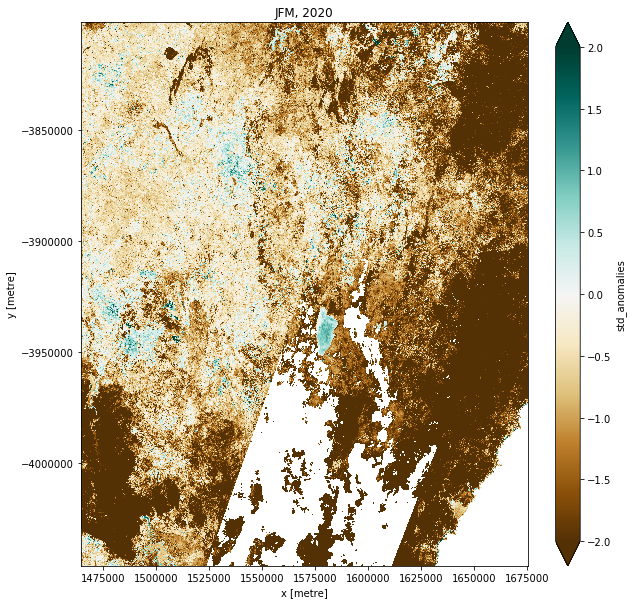

In [13]:
anomalies.std_anomalies.plot(figsize=(10,10), vmin=-2.0, vmax=2.0, cmap='BrBG')

plt.title(season+ ", " +year)
plt.show()